# Opdracht schilderijen

In [1]:
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# importeren van zelf geschreven callback
from Callbacks.RealTimePlotCallback import RealTimePlotCallback

Inlezen van de train-, validatie- en testdata op basis van de verschillende directories waarin we de data hebben opgesplitst. We lezen deze in met behulp van de geïmporteerde image_dataset_from_directory functie van keras.utils.

In [2]:
train_data = image_dataset_from_directory("dataset/train", image_size=(180, 180))
val_data = image_dataset_from_directory("dataset/validation", image_size=(180, 180))
test_data = image_dataset_from_directory("dataset/test", image_size=(180, 180))

Found 3672 files belonging to 4 classes.
Found 1220 files belonging to 4 classes.
Found 1224 files belonging to 4 classes.


## Modellen uit boek

### Eenvoudig convnet (zonder data augmentation)

#### Listing 8.7 (p215)

Zoals in de opgave gevraagd wordt, zal ik beginnen met het convnet uit Listing 8.7 (p215) van de Cats & Dogs oefening. Ik maak de nodige aanpassingen aan het model zodat deze gebruikt kan worden voor deze opdracht. Namelijk het aantal units van de output Dense layer verander ik naar 4, omdat we met 4 klassen werken (4 schilders). Ik verander ook de activatiefunctie van sigmoid naar softmax, omdat we niet meer met binaire classificatie werken maar met multiclass single-label classification. Ik maak ook gebruik van de sparse_categorical_crossentropy loss-functie in plaats van binary_crossentropy voor dezelfde reden.

Ik maak deze aanpassingen voor ieder model in deze notebook.

In [3]:
input_layer = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(input_layer)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(4, activation="softmax")(x)  # 4 because we have 4 classes (0 through 3)

model = keras.Model(inputs=input_layer, outputs=outputs)

# Return the compiled model
model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=keras.optimizers.RMSprop(),
  metrics=["accuracy"],
)

Ik maak gebruik van verschillende callbacks tijdens het fitten van mijn model.
 - **ModelCheckpoint** om het beste model op te slaan op basis van de validation loss. Deze modellen worden opgeslagen in de 'models' directory.
 - **EarlyStopping** om het fitten vervroegd te stoppen wanneer de validation accuracy niet meer verbeterd. Ik heb hiervoor een patience van 10 epochs (10% van 100 epochs) ingesteld. Wanneer de validation accuracy al 10 epochs niet meer verbeterd, zal het trainen stoppen. Zo wordt er gestopt wanneer er overgefit wordt en wordt er niet nodeloos verder getraind.
 - **RealTimePlotCallback**, een zelfgeschreven callback om de training en vaidatie accuracy en loss na iedere epoch te plotten. (U vindt de code hiervan in 'Callbacks' folder.)

<Figure size 640x480 with 0 Axes>

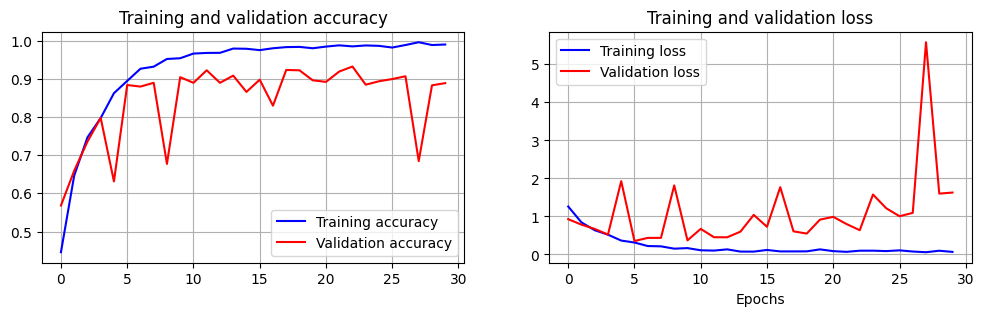

training loss: 0.06668410450220108
validation loss: 1.6280289888381958
training accuracy: 0.9896514415740967
validation accuracy: 0.88852459192276

epochs: 30

115/115 [==============================] - 8s 63ms/step - loss: 0.0667 - accuracy: 0.9897 - val_loss: 1.6280 - val_accuracy: 0.8885


In [4]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="models/convnet_p215.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=callbacks_list
)


In [5]:
# model.summary()

### Eenvoudig convnet met data augmentation

#### Listing 8.14 (p221) & 8.16 (p223)

In [6]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

input_layer = keras.Input(shape=(180, 180, 3))
x = data_augmentation(input_layer)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)  # 4 because we have 4 classes (0 through 3)

model = keras.Model(inputs=input_layer, outputs=outputs)

# Return the compiled model
model.compile(
  loss="sparse_categorical_crossentropy",
  optimizer=keras.optimizers.RMSprop(),
  metrics=["accuracy"],
)

<Figure size 640x480 with 0 Axes>

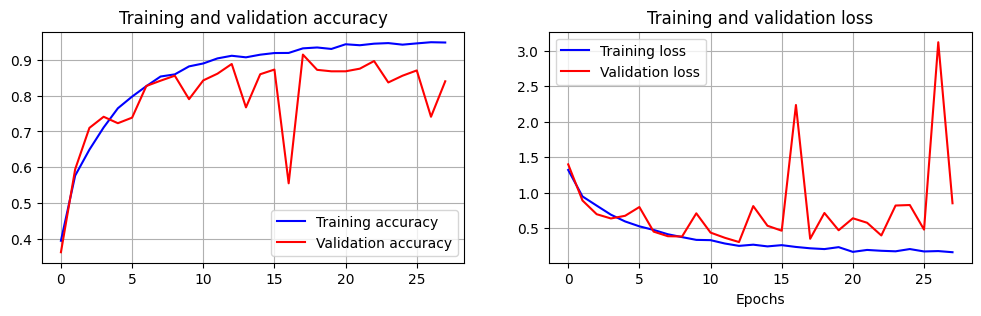

training loss: 0.16419585049152374
validation loss: 0.8533914685249329
training accuracy: 0.9485294222831726
validation accuracy: 0.8401639461517334

epochs: 28

115/115 [==============================] - 38s 329ms/step - loss: 0.1642 - accuracy: 0.9485 - val_loss: 0.8534 - val_accuracy: 0.8402


In [7]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="models/convnet_p223_data_augmentation.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=callbacks_list
)

### Feature extraction met VGG16

#### Listing 8.19 (p227) en 8.20 (p229)

In [8]:
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False,
 input_shape=(180, 180, 3))


def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_data)
val_features, val_labels = get_features_and_labels(val_data)
test_features, test_labels = get_features_and_labels(test_data)

1/1 [==============================] - 1s 1s/step


Ik vraag de shape van de train features op, deze wordt dan als input shape gegeven.

In [9]:
train_features.shape

(3672, 5, 5, 512)

#### Listing 8.21 (p229)

In [10]:
inputs = keras.Input(shape=(5, 5, 512)) # train_features.shape
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)  # 4 because we have 4 classes (0 through 3)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

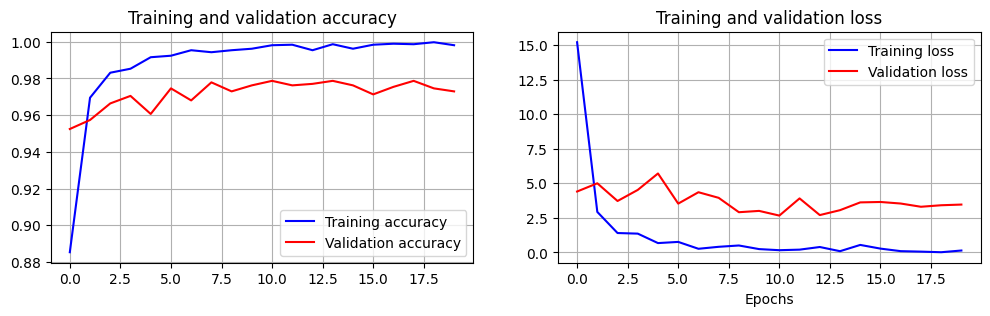

training loss: 0.14099712669849396
validation loss: 3.465117931365967
training accuracy: 0.9980936646461487
validation accuracy: 0.97295081615448

epochs: 20

115/115 [==============================] - 1s 8ms/step - loss: 0.1410 - accuracy: 0.9981 - val_loss: 3.4651 - val_accuracy: 0.9730


In [11]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="models/feature_extraction_VGG16.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_features, train_labels,
         epochs=20,
         validation_data=(val_features, val_labels),
         callbacks=callbacks_list)

### Feature extraction met VGG16 (nu met data augmentation)

#### Listing 8.23 (p231) & 8.25 (p232)

In [34]:
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False)
conv_base.trainable = False


data_augmentation = keras.Sequential(
     [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
     ]
)
input_layer = keras.Input(shape=(180, 180, 3))
x = data_augmentation(input_layer)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(input_layer, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

<Figure size 640x480 with 0 Axes>

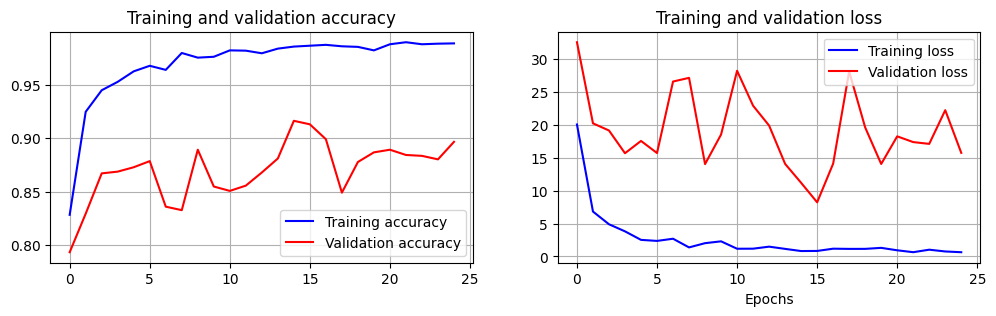

training loss: 0.6368107199668884
validation loss: 15.739765167236328
training accuracy: 0.9888344407081604
validation accuracy: 0.8967213034629822

epochs: 25

115/115 [==============================] - 42s 365ms/step - loss: 0.6368 - accuracy: 0.9888 - val_loss: 15.7398 - val_accuracy: 0.8967


In [35]:
callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="models/feature_extraction_VGG16_data_augmentation.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
         train_data,
         epochs=50,
         validation_data=val_data,
         callbacks=callbacks_list)

### Finetuning van VGG16 conv base

#### Listing 8.27 (p236) & 8.28 (p236)

<Figure size 640x480 with 0 Axes>

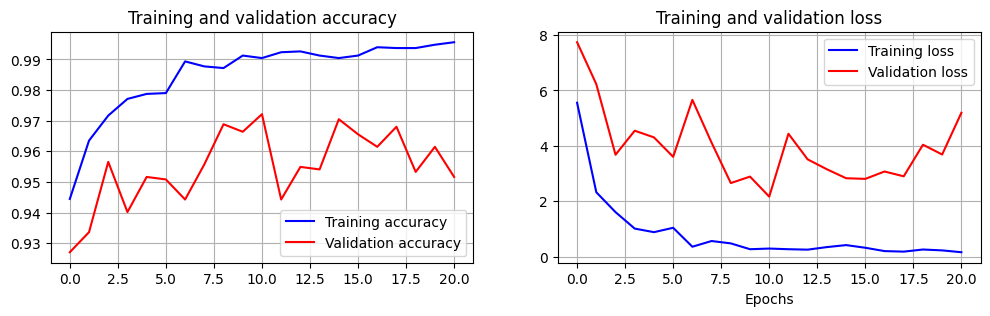

training loss: 0.15949243307113647
validation loss: 5.19251012802124
training accuracy: 0.9956427216529846
validation accuracy: 0.9516393542289734

epochs: 21

115/115 [==============================] - 45s 384ms/step - loss: 0.1595 - accuracy: 0.9956 - val_loss: 5.1925 - val_accuracy: 0.9516


In [36]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False


model.compile(loss="sparse_categorical_crossentropy",
     optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
     metrics=["accuracy"])

callbacks_list = [
     keras.callbacks.ModelCheckpoint(
     filepath="models/finetuned_conv_base_VGG16.keras",  # file waarin model wordt opgeslagen
     save_best_only=True,  # beste model wordt opgeslagen obv validation loss!
     monitor="val_loss"),
     keras.callbacks.EarlyStopping(
     monitor="val_accuracy",
     patience=10,
     ),
     RealTimePlotCallback()
]

history = model.fit(
     train_data,
     epochs=30,
     validation_data=val_data,
     callbacks=callbacks_list)